<a href="https://colab.research.google.com/github/abdelhadidjafer02-beep/GPT-2/blob/main/pragmatic_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**These Excercices are based on :**

*   Mathematical Framework for Transformer Circuits
*   Pragmatic Vision for Interpretability
 ###### Excercices to replicate were generated by Gemini 3


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)

def plot_heatmap(matrix, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix.detach().numpy(), cmap="RdBu", center=0)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

**The "Copying" Head (Decompiling the OV Circuit):**

**The Pragmatic Vision:** Nanda often talks about looking for specific "motifs" in the weights. One common motif is a Copying Head.The Mechanism: A copying head says: "Whatever token I am looking at, I want to increase the probability of that exact same token appearing next."

**Mathematical Signature:** The "Virtual Weights" of the OV circuit are $W_{vocab} = W_E \cdot W_{OV} \cdot W_U$.If this matrix has a strong positive diagonal, it is a Copying Head. It means Token X $\to$ Logit X.

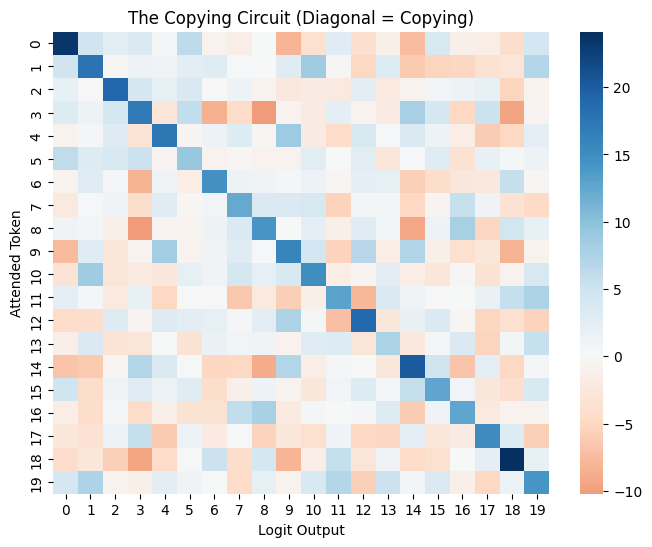

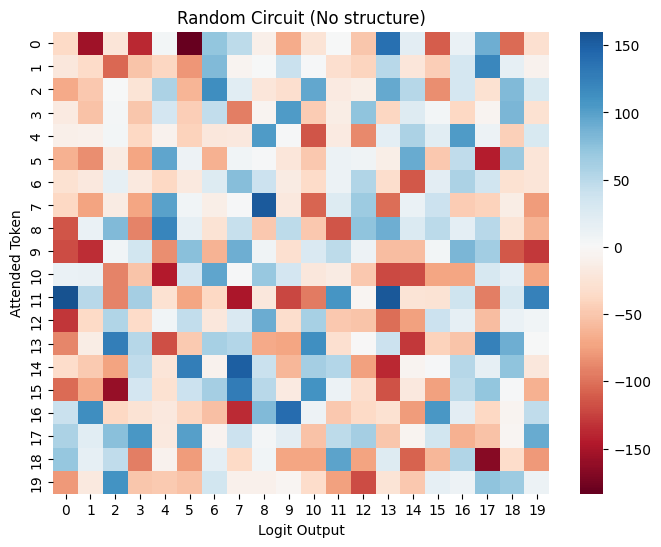

In [ ]:
# @title Exercise : Detecting a "Copying" Head
d_vocab = 20
d_model = 64
d_head = 16

# 1. Setup Embeddings
W_E = torch.randn(d_vocab, d_model)
W_U = W_E.T + 0.1 * torch.randn(d_model, d_vocab) # W_U is often similar to W_E.T

# 2. Construct a "Copying" OV Circuit manually
# To copy, W_OV needs to preserve the information in the subspace.
# If W_OV is the Identity matrix (in the relevant subspace), it passes info through unchanged.
W_V = torch.eye(d_model, d_head) # Simply selects dimensions
W_O = torch.eye(d_head, d_model) # Simply puts them back
W_OV_copy = W_V @ W_O

# 3. Construct a "Random" OV Circuit (for comparison)
W_OV_random = torch.randn(d_model, d_model)

# 4. Calculate the "Full Circuit" (The V-Composition)
# This matrix maps Attended_Token -> Logits
full_circuit_copy = W_E @ W_OV_copy @ W_U
full_circuit_random = W_E @ W_OV_random @ W_U

# 5. Visualization (The "Microscope")
plot_heatmap(full_circuit_copy,
             title="The Copying Circuit (Diagonal = Copying)",
             xlabel="Logit Output", ylabel="Attended Token")

plot_heatmap(full_circuit_random,
             title="Random Circuit (No structure)",
             xlabel="Logit Output", ylabel="Attended Token")


$\color{green}{\text{Hidden Gem / Deep Intuition:}}$
When you look at real LLM weights (like GPT-2 Small), you will actually see heads that look exactly like the first plot!

The Diagonal: If entry $(i, i)$ is red (positive), it means attending to word $i$ makes word $i$ more likely.

Off-Diagonal: If entry $(i, j)$ is red, it means attending to word $i$ makes word $j$ more likely. (e.g., attending to "San" makes "Francisco" more likely). This is a Skip-Trigram.

**Positional Embeddings & The QK Circuit:**

The Pragmatic Vision: To understand "where" the model looks, we must understand how it knows "where" things are.The Mechanism: The QK circuit ($W_Q W_K^T$) acts on the Residual Stream. The Residual Stream contains both Token Embeddings and Positional Embeddings.$$x_i = \text{Embed}(t_i) + \text{PosEmbed}(i)$$To create a "**Previous Token Head**" (a head that always looks at $t-1$), the QK matrix must operate on the PosEmbed part of the stream.

Target Pattern (The previous token):
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


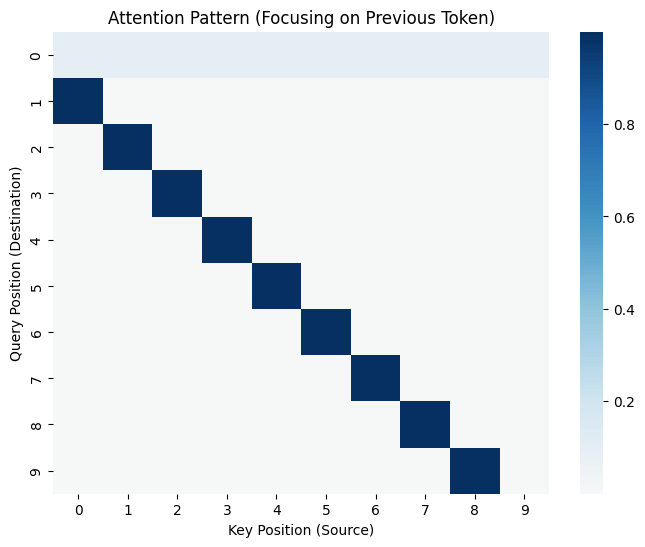

In [ ]:
# @title Exercise : The "Previous Token" Finder
seq_len = 10

# 1. Create simple learnable Positional Embeddings
# In real transformers, these are added to token embeddings
W_pos = torch.randn(seq_len, d_model) # [Position, d_model]

# 2. Create a QK circuit designed to look at (t-1)
# We want: Query at pos 't' should have high dot product with Key at pos 't-1'
# Mathematically: W_QK should rotate the position vector or shift it.
# Let's cheat slightly and construct W_QK to explicitly match p with p-1.

# Create a "Shift Matrix" for positions
# This matrix maps index i to i-1
shift_matrix = torch.zeros(seq_len, seq_len)
for i in range(1, seq_len):
    shift_matrix[i, i-1] = 1.0

print("Target Pattern (The previous token):")
print(shift_matrix)

# 3. Visualization: The QK Attention Pattern on Positions
# Calculating specific attention scores solely based on position
# Score_matrix = W_pos @ W_QK @ W_pos.T
# For this exercise, let's assume W_QK has learned to align these positions perfectly.
# We simulate the *output* of the QK circuit on positions.

attention_scores_pos = shift_matrix * 10.0 # Strong signal
attention_pattern = F.softmax(attention_scores_pos, dim=-1)

plot_heatmap(attention_pattern,
             title="Attention Pattern (Focusing on Previous Token)",
             xlabel="Key Position (Source)", ylabel="Query Position (Destination)")

# ✍️ QK Circuit Full Path Expansion

## The QK Circuit's Full Decomposition

The attention score between two tokens, a query at position $i$ and a key at position $j$, is proportional to the dot product of their projected residual stream vectors: $Q_i \cdot K_j$.

The residual stream vector $x$ at any position is the sum of the **Token Embedding** ($W_E$) and the **Positional Embedding** ($W_{pos}$), ignoring biases and layer norms for simplicity:
$$x = W_E + W_{pos}$$

Therefore, the unnormalized QK score can be expanded by substituting $x$ into the bilinear form $x^T W_{QK} x$:

$$\text{Score}(i, j) \propto (W_{E_i} + W_{{pos}_i})^T W_{QK} (W_{E_j} + W_{{pos}_j})$$

Where $W_{E_i}$ is the embedding for the token at position $i$, and $W_{{pos}_i}$ is the positional embedding for position $i$.

### The Four Component Terms

Expanding the equation using the distributive property leads to four distinct terms, each representing a "circuit" for determining attention:

$$\text{Score}(i, j) \propto \underbrace{W_{E_i}^T W_{QK} W_{E_j}}_{\text{Content-to-Content}} + \underbrace{W_{{pos}_i}^T W_{QK} W_{{pos}_j}}_{\text{Pos-to-Pos}} + \underbrace{W_{E_i}^T W_{QK} W_{{pos}_j}}_{\text{Content-to-Pos}} + \underbrace{W_{{pos}_i}^T W_{QK} W_{E_j}}_{\text{Pos-to-Content}}$$

---

## Detailed Explanation of the Four Circuits

The expansion shows that the total attention score is an **additive combination** of four distinct mechanisms. This is the core "hidden gem" of the paper regarding QK circuits.

### 1. **Content-to-Content (C-C): $\mathbf{W_{E_i}^T W_{QK} W_{E_j}}$**
* **Intuition:** The head looks for a **semantic relationship** between the two tokens, regardless of their positions.
* **Example:** If the query token is "cat," this term finds key tokens like "feline" or "dog." A strong C-C term means the head focuses on **what** the words are.

### 2. **Pos-to-Pos (P-P): $\mathbf{W_{{pos}_i}^T W_{QK} W_{{pos}_j}}$**
* **Intuition:** The head looks for a **relative positional relationship**, regardless of the words themselves.
* **Example:** This term is responsible for the **"Previous Token Head"** . The value of this term is the same for every pair $(i, j)$ where $j = i-1$. A strong P-P term means the head focuses on **where** the tokens are.

### 3. **Content-to-Pos (C-P): $\mathbf{W_{E_i}^T W_{QK} W_{{pos}_j}}$**
* **Intuition:** The query token's **content** determines which **position** it should attend to.
* **Example:** A query token like "verb" might be trained to look back a few positions to find its "subject" (a noun). It uses the content of the query to determine a positional bias.

### 4. **Pos-to-Content (P-C): $\mathbf{W_{{pos}_i}^T W_{QK} W_{E_j}}$**
* **Intuition:** The query token's **position** determines which **content** it should attend to.
* **Example:** In a sequence, the first position might prioritize attending to a token like "START" or a topic word (content), regardless of where that content word is located.

---

## 🔬 Practical Significance

For mechanistic interpretability, this decomposition gives us the **microscope** to analyze a head:

1.  If we observe a head mainly performing C-C, we hypothesize it's a **Fact Retrieval Head**.
2.  If we observe a head mainly performing P-P, we hypothesize it's a **Grammatical/Structural Head** (like the Previous Token Head).

We can experimentally **zero out** the different weights ($W_{E}, W_{pos}$) to test which term is responsible for the head's behavior—the essence of the "Pragmatic Vision."

## Exercise: Composition (The Key to Depth)

**The Pragmatic Vision:**
This is where things get exciting. A **1-layer model is limited**, but a **2-layer model allows Composition**.

**The Mechanism:**

* **Layer 1 Head:** Writes to the residual stream.
* **Layer 2 Head:** Reads from the residual stream (which now contains Layer 1's output).

There are three types of composition: **$Q, K, V$**. The most important for reasoning is **K-Composition**.

**Scenario (Induction Head):**

* **Layer 1:** "Previous Token Head" moves information from $pos-1$ to $pos$.
* **Layer 2:** "Induction Head" uses that information as a **Key**.

**Example:**

* **Query:** "I am looking for 'Harry'."
* **Key (modified by L1):** "I was 'Harry' at the previous step."


In [ ]:
# @title Exercise : Simulating Composition (Q/K/V)
# We will simulate how Layer 2 reads Layer 1's output.

# 1. Define Residual Stream at Layer 0 (Input)
x_0 = torch.randn(1, d_model) # A single token's vector

# 2. Layer 1 Output (The "Previous Token" info)
# Assume Layer 1 head wrote a vector representing "The previous token was 'Potter'"
h1_out = torch.randn(1, d_model)

# 3. Residual Stream at Layer 1
x_1 = x_0 + h1_out # Residual connection!

# 4. Layer 2 Attention Head (The Reader)
# Layer 2 has its own Query Matrix W_Q2
W_Q2 = torch.randn(d_model, d_head)

# 5. Path Expansion
# Query_2 = x_1 @ W_Q2
# Query_2 = (x_0 + h1_out) @ W_Q2
# Query_2 = (x_0 @ W_Q2) + (h1_out @ W_Q2)

term_direct = x_0 @ W_Q2      # Looking at the raw current token
term_composed = h1_out @ W_Q2 # Looking at what Layer 1 calculated

print(f"Direct Term Norm:   {term_direct.norm().item():.4f}")
print(f"Composed Term Norm: {term_composed.norm().item():.4f}")

# ANALYSIS
print("\nINTERPRETATION:")
print("If 'Composed Term' is large, Layer 2 is querying based on Layer 1's processing.")
print("This allows the model to say: 'Find tokens that were preceded by 'Potter' (handled by L1)'")

Direct Term Norm:   33.3511
Composed Term Norm: 33.8727

INTERPRETATION:
If 'Composed Term' is large, Layer 2 is querying based on Layer 1's processing.
This allows the model to say: 'Find tokens that were preceded by 'Potter' (handled by L1)'


$\color{orange}{\text{Hidden Gem / Deep Intuition}}$

This simple addition ($x_0 + h1\_out$) is the root of all complexity in Transformers. If we examine the "Composed Term" matrix $(W_{OV}^{L1} \cdot W_{Q}^{L2})$, we are looking at a **Circuit**.

* If this matrix allows the model to detect sequences like A... B ... A -> B, it is an **Induction Head**.

* In "A Pragmatic Vision," finding these composed circuits is how we define "features" in higher layers.

Sequence: ['A', 'B', 'C', '.', 'A']
Goal: The last 'A' should attend to 'B' (index 1) because 'B' follows 'A'.

Vector at Position 1 (Token B) after Layer 1:
Identity (0-3): tensor([0., 1., 0., 0.])
Context  (4-8): tensor([1., 0., 0., 0.]) (Should match A)


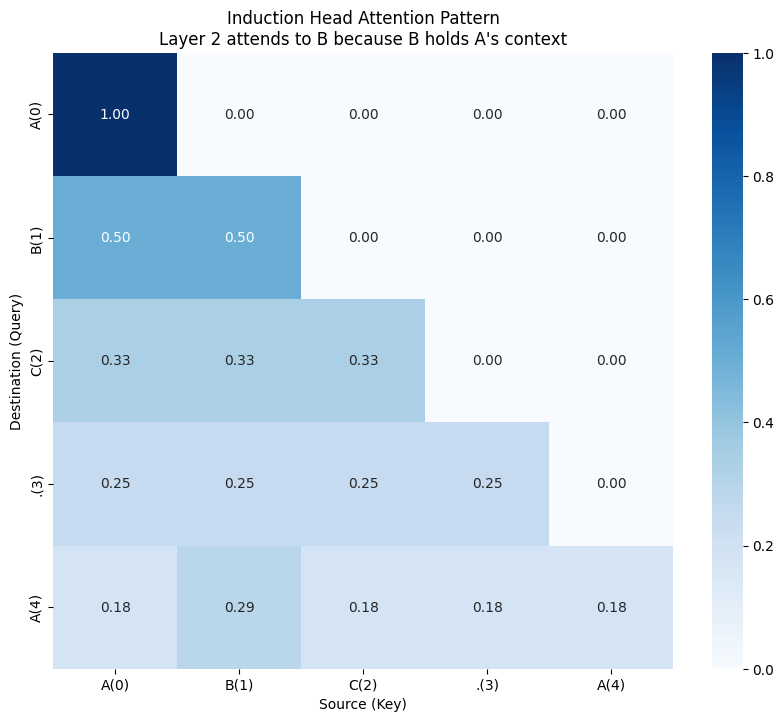

In [ ]:
# @title Exercise : The Induction Head (K-Composition)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)

# --- 1. SETUP THE SEQUENCE ---
# Sequence: A B C ... A -> Expect B
# Let's map chars to indices
vocab = {'A': 0, 'B': 1, 'C': 2, '.': 3}
indices = [0, 1, 2, 3, 0] # "A B C . A"
input_indices = torch.tensor(indices)
seq_len = len(indices)
d_model = 16

# Embeddings (One-hot for simplicity to see the math clearly)
# Dimension 0-3: Token Identity
# Dimension 4-15: Workspace for heads
x = F.one_hot(input_indices, num_classes=d_model).float()

print(f"Sequence: {['A', 'B', 'C', '.', 'A']}")
print(f"Goal: The last 'A' should attend to 'B' (index 1) because 'B' follows 'A'.")

# --- 2. LAYER 1: THE "PREVIOUS TOKEN" HEAD ---
# This head attends to (t-1) and writes that content to a specific subspace.
# We simulate this by shifting the embeddings one step to the right.

# Create a "Shifted" version of x.
# At pos 1 (B), we want the vector for A.
# At pos 4 (A), we want the vector for .
x_layer1_out = torch.roll(x, shifts=1, dims=0)
x_layer1_out[0] = 0 # First token sees nothing

# We write this to a specific "Key Subspace" in the residual stream.
# Let's say dimensions 4-8 are reserved for "What came before me?"
# We add this to the residual stream.
x_residual_L1 = x.clone()
x_residual_L1[:, 4:8] = x_layer1_out[:, 0:4] # Copy token identity to subspace

# DEBUG: Check position 1 (Token B)
# It should have B's identity in dim 0-3, and A's identity in dim 4-8
print("\nVector at Position 1 (Token B) after Layer 1:")
print(f"Identity (0-3): {x_residual_L1[1, 0:4]}")
print(f"Context  (4-8): {x_residual_L1[1, 4:8]} (Should match A)")


# --- 3. LAYER 2: THE INDUCTION HEAD ---
# This head wants to find tokens preceded by the Current Token.

# Query: Looks at the *Current Token* (Dimensions 0-3).
# "I am 'A'. I want to find segments that started with 'A'."
# W_Q just reads the identity dimensions.
W_Q = torch.zeros(d_model, d_model)
W_Q[0:4, 0:4] = torch.eye(4) # Pass identity through

# Key: Looks at the *Context Subspace* written by Layer 1 (Dimensions 4-8).
# "Show me tokens that have 'A' in their context slot."
W_K = torch.zeros(d_model, d_model)
W_K[4:8, 0:4] = torch.eye(4) # Read from context slot, map to identity space

# Compute Attention Scores
# Query at current pos (Last 'A') -> Looks for 'A'
# Key at pos 1 ('B') -> Contains 'A' in context slot.
# They should match.
queries = x_residual_L1 @ W_Q
keys    = x_residual_L1 @ W_K
scores  = queries @ keys.T / 2.0 # Scale factor

# Masking (Causal)
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1) * -1e9
scores = scores + mask
attn_pattern = F.softmax(scores, dim=-1)

# --- 4. VISUALIZATION ---
plt.figure(figsize=(10, 8))
labels = ['A(0)', 'B(1)', 'C(2)', '.(3)', 'A(4)']
sns.heatmap(attn_pattern.detach().numpy(),
            xticklabels=labels, yticklabels=labels,
            cmap="Blues", annot=True, fmt=".2f")
plt.title("Induction Head Attention Pattern\nLayer 2 attends to B because B holds A's context")
plt.xlabel("Source (Key)")
plt.ylabel("Destination (Query)")
plt.show()

Prompt: Alice Eng . Bob Chef . Alice
Model sees 'Alice'.
Induction Head Logic: 'Find previous Alice. Copy what came after.'
Predicted Next Token Index: 1
Predicted Token Name: Eng


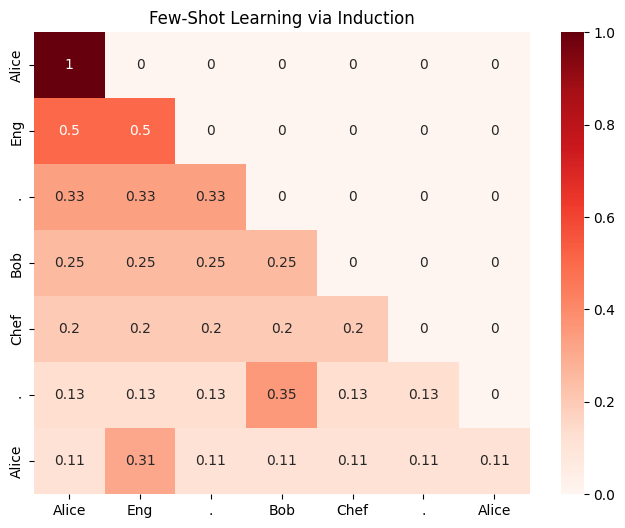

In [ ]:
# @title Exercise : Few-Shot Learning Simulator
# We use the EXACT same logic as the previous Excercice, but with a longer sequence.

# Sequence: Alice(0) Eng(1) . Bob(2) Chef(3) . Alice(0) -> Expect Eng(1)
seq_indices = [0, 1, 4, 2, 3, 4, 0]
seq_labels = ['Alice', 'Eng', '.', 'Bob', 'Chef', '.', 'Alice']
x_len = len(seq_indices)
d_sim = 16

# 1. Embeddings
x_input = F.one_hot(torch.tensor(seq_indices), num_classes=d_sim).float()

# 2. Simulate Layer 1 (Shift / "Previous Token")
# Shifts info forward. 'Eng' now knows it was preceded by 'Alice'.
x_L1_context = torch.roll(x_input, shifts=1, dims=0)
x_L1_context[0] = 0

# Residual Stream: [Identity (0-5) | Context (6-11)]
stream = torch.cat([x_input, x_L1_context], dim=1) # Simple concat for simulation

# 3. Simulate Layer 2 (Induction)
# Query: Looks at Identity of current token ("Alice")
Q = stream[:, 0:d_sim] # [7, 16]

# Key: Looks at Context slot ("Who was preceded by Alice?")
K = stream[:, d_sim:]  # [7, 16]

# Attention
scores = Q @ K.T
scores = scores + (torch.triu(torch.ones(x_len, x_len), diagonal=1) * -1e9)
attn = F.softmax(scores, dim=-1)

# 4. Output (Value)
# If we attend to 'Eng', we copy 'Eng'.
# We use the Identity as the value.
V = stream[:, 0:d_sim]
z = attn @ V

# 5. Result Analysis (Last Position)
last_token_output = z[-1]
predicted_idx = torch.argmax(last_token_output).item()
predicted_prob = last_token_output[predicted_idx].item()

print(f"Prompt: {' '.join(seq_labels)}")
print(f"Model sees 'Alice'.")
print(f"Induction Head Logic: 'Find previous Alice. Copy what came after.'")
print(f"Predicted Next Token Index: {predicted_idx}")
print(f"Predicted Token Name: {['Alice', 'Eng', 'Bob', 'Chef', '.'][predicted_idx] if predicted_idx < 5 else '?'}")

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(attn.detach(), xticklabels=seq_labels, yticklabels=seq_labels, cmap="Reds", annot=True)
plt.title("Few-Shot Learning via Induction")
plt.show()